In [1]:
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import numpy as np
import pandas as pd
%precision 4
plt.style.use('ggplot')
np.random.seed(1234)
import pymc3 as pm
import theano.tensor as tt
import scipy.stats as stats
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
from datetime import datetime, date, time
import supportfun
import mcmc_models
import math
from scipy.stats import poisson
import logging
_logger = logging.getLogger("theano.gof.compilelock")
_logger.setLevel(logging.ERROR)

/Users/Xin/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/Xin/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
# connect to database
user = 'Xin' #add your username here (same as previous postgreSQL)                      
host = 'localhost'
dbname = 'spire_user'
con = None
con = psycopg2.connect(database = dbname, user = user)

In [15]:
# load user data from database
userid = 5
# query
sql_query = "SELECT * FROM user_data as ud INNER JOIN user_id as ui ON ud.md5 = ui.md5 WHERE ui.index = %i;" %(userid)
data_from_sql = pd.read_sql_query(sql_query,con)

In [16]:
df_short = data_from_sql.iloc[:,[0, 2, 5, 6, 8, 9, 10, 11, 12, -3, -5, -6, -7]]

In [17]:
hour = supportfun.hours(df_short)
df_short["hours"] = hour

/Users/Xin/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [19]:
#df_short_cut = df_short[df_short.streak_type != "inactive"]
df_short_cut = df_short
df_short_cut.streak_type = df_short_cut.streak_type.astype(float)

/Users/Xin/anaconda/envs/py27/lib/python2.7/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [20]:
df_tmp = df_short_cut.groupby(["start_ymd","hours","streak_type", "time_len"])
df_freq = df_tmp.sum()
df_freq = df_freq.reset_index()
df_tmp1 = df_freq.groupby(["start_ymd","hours","streak_type"]).sum()
df_freq = df_tmp1.reset_index()
df_freq = df_freq.iloc[:, [0, 1, 2, 3]]

In [21]:
year = {}
month = {}
day = {}
weekday = {}
for i in range(len(df_freq.start_ymd)):
    dt = datetime.strptime(df_freq.start_ymd[i], "%Y-%m-%d")
    year[i] = dt.year
    month[i] = dt.month
    day[i] = dt.day
    weekday[i] = dt.weekday()
df_freq['year'] = year.values()
df_freq['month'] = month.values()
df_freq['day'] = day.values()
df_freq['weekday'] = weekday.values() # monday is 0, sunday is 6

In [22]:
df_hourly = df_freq.groupby(["hours", "streak_type"]).mean().reset_index()

In [23]:
type_ratio = df_hourly.time_len/3600
df_hourly = df_hourly.iloc[:, 0:2]
df_hourly["type_ratio"] = type_ratio

In [24]:
df_freq_long = df_freq.merge(df_hourly, how = "left", left_on = ["hours", "streak_type"], right_on = ["hours", "streak_type"])
df_freq_long.head()

,start_ymd,hours,streak_type,time_len,year,month,day,weekday,type_ratio
0,2014-12-21,8,0.0,1264.0,2014,12,21,6,0.191441
1,2014-12-21,9,0.0,540.0,2014,12,21,6,0.208692
2,2014-12-21,9,2.0,422.0,2014,12,21,6,0.128417
3,2014-12-21,10,0.0,541.0,2014,12,21,6,0.214119
4,2014-12-21,14,0.0,483.0,2014,12,21,6,0.178397


In [25]:
g11 = df_freq_long[df_freq_long.streak_type == 0]
g22 = df_freq_long[df_freq_long.streak_type == 1]
g33 = df_freq_long[df_freq_long.streak_type == 2]
np1 = []
np2 = []
np3 = []
for i in range(len(g11.streak_type)):
    np1.append(np.datetime64(g11.start_ymd.iloc[i]))
for i in range(len(g22.streak_type)):
    np2.append(np.datetime64(g22.start_ymd.iloc[i]))
for i in range(len(g33.streak_type)):
    np3.append(np.datetime64(g33.start_ymd.iloc[i]))

In [26]:
g11_short = g11.start_ymd.value_counts().index.sort_values(ascending = False)[:(len(g11.start_ymd.value_counts().index.sort_values(ascending = False))-354)]

In [27]:
g11 = g11.merge(pd.DataFrame(g11_short), left_on = "start_ymd", right_on = 0, how = "inner")

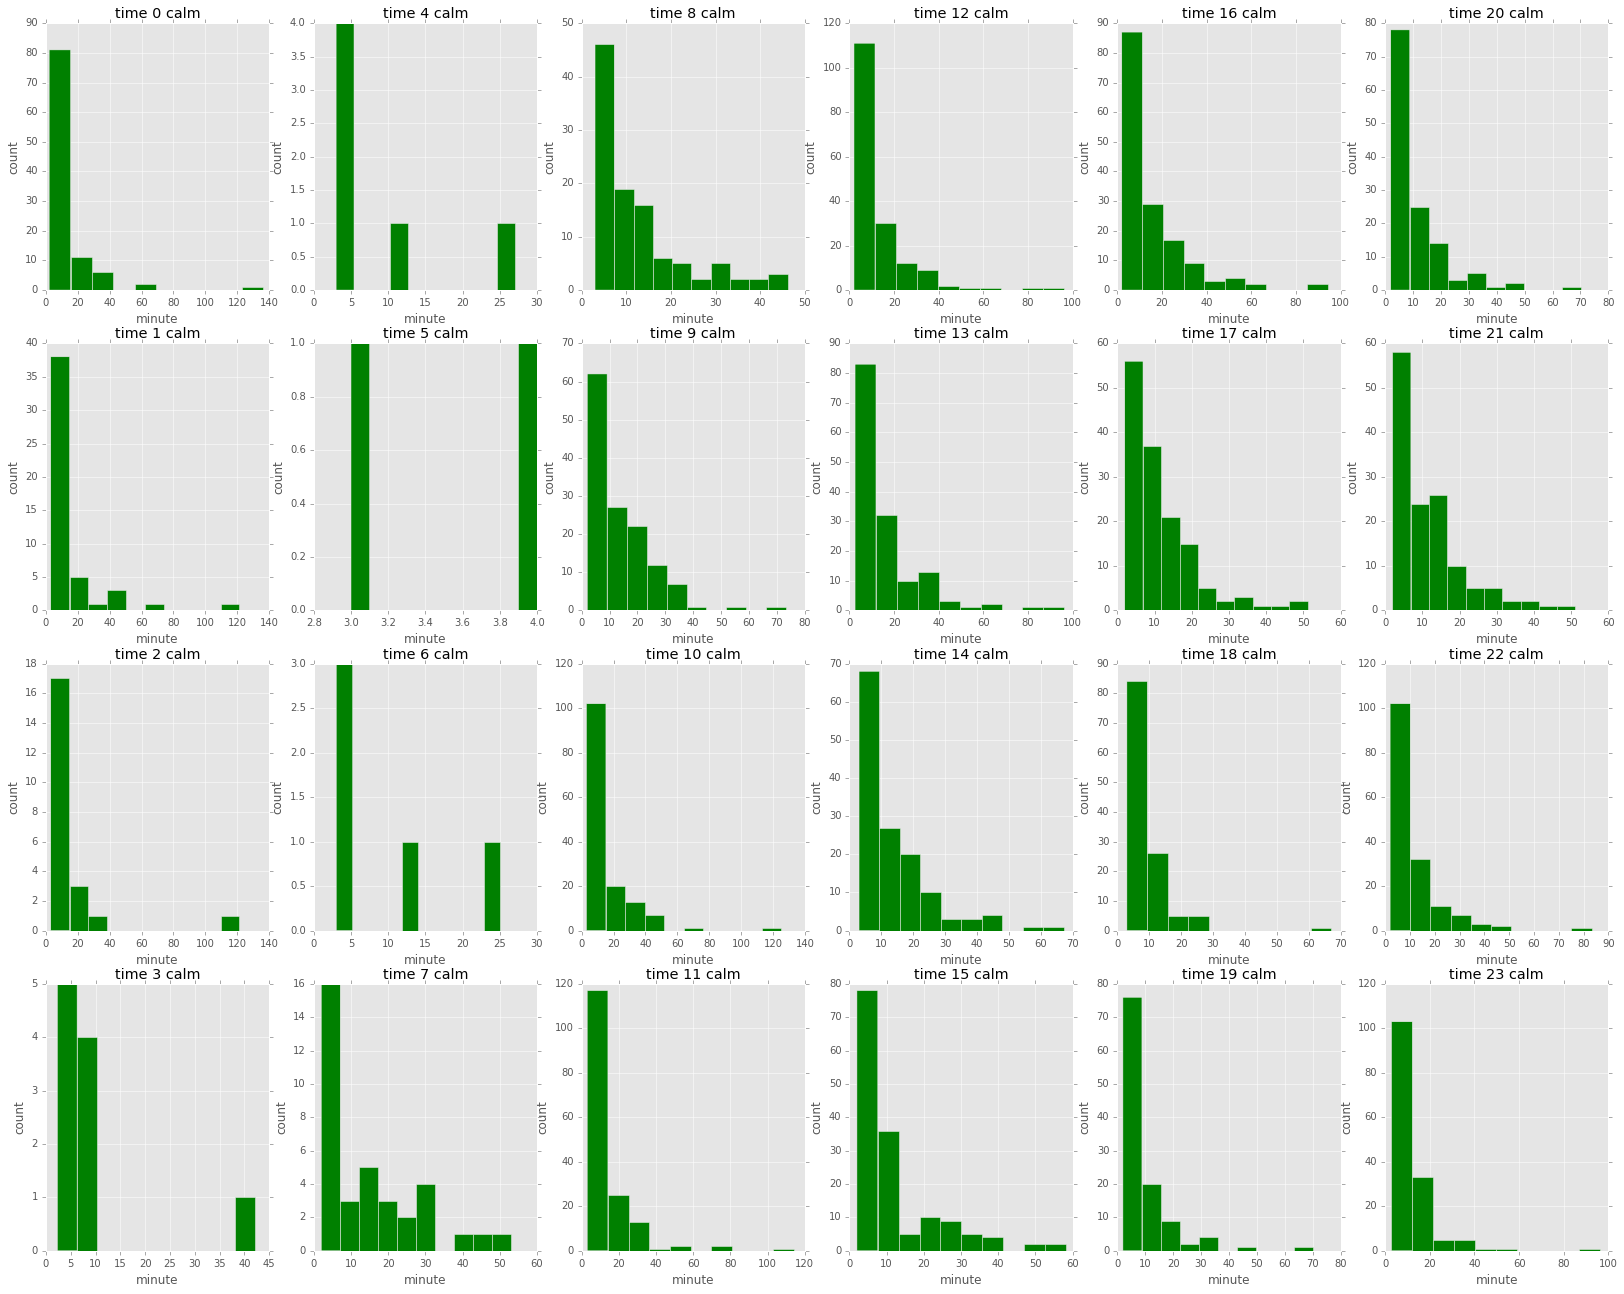

In [28]:
supportfun.hourly_count(g11, 'g', 'calm')

In [29]:
g22_short = g22.start_ymd.value_counts().index.sort_values(ascending = False)[:(len(g22.start_ymd.value_counts().index.sort_values(ascending = False))-354)]

In [30]:
g22 = g22.merge(pd.DataFrame(g22_short), left_on = "start_ymd", right_on = 0, how = "inner")

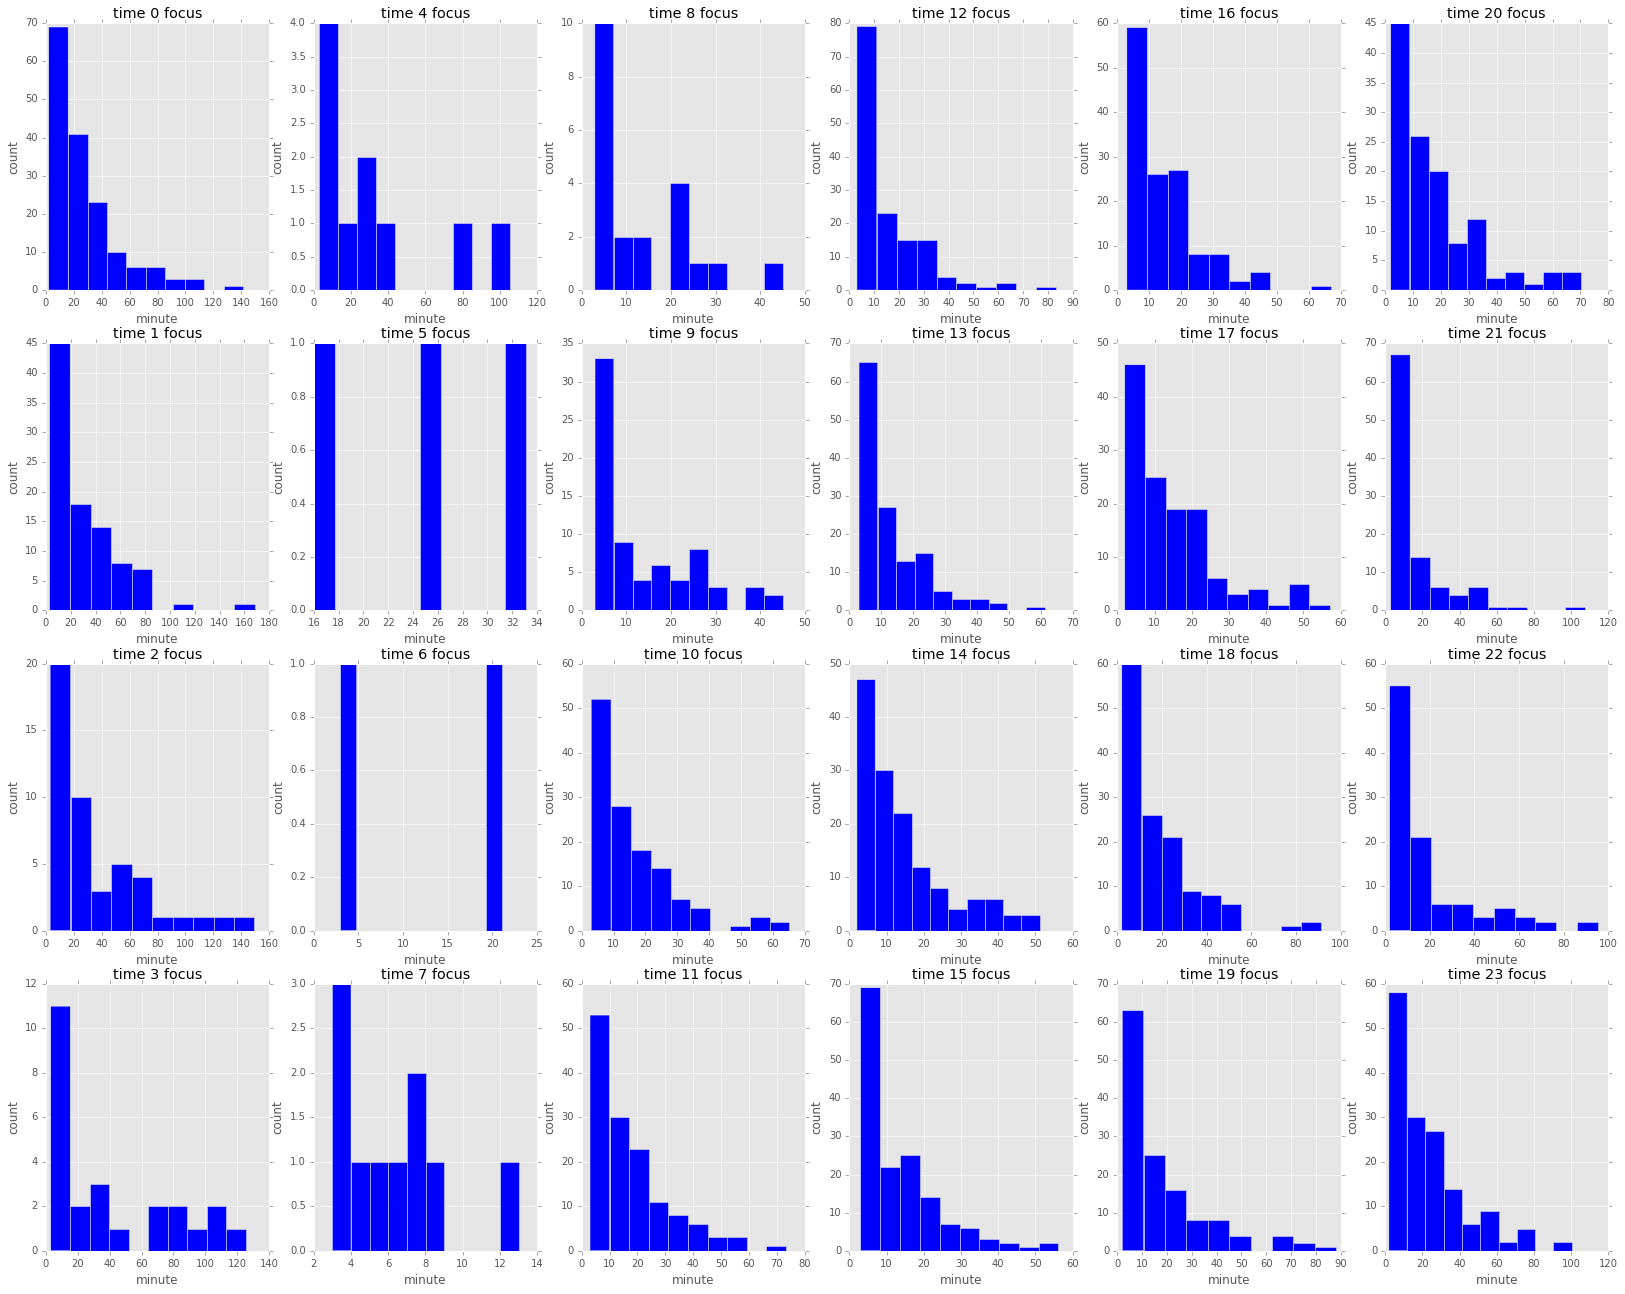

In [31]:
supportfun.hourly_count(g22, 'b', 'focus')

In [32]:
g33_short = g33.start_ymd.value_counts().index.sort_values(ascending = False)[:(len(g33.start_ymd.value_counts().index.sort_values(ascending = False))-354)]

In [33]:
g33 = g33.merge(pd.DataFrame(g33_short), left_on = "start_ymd", right_on = 0, how = "inner")

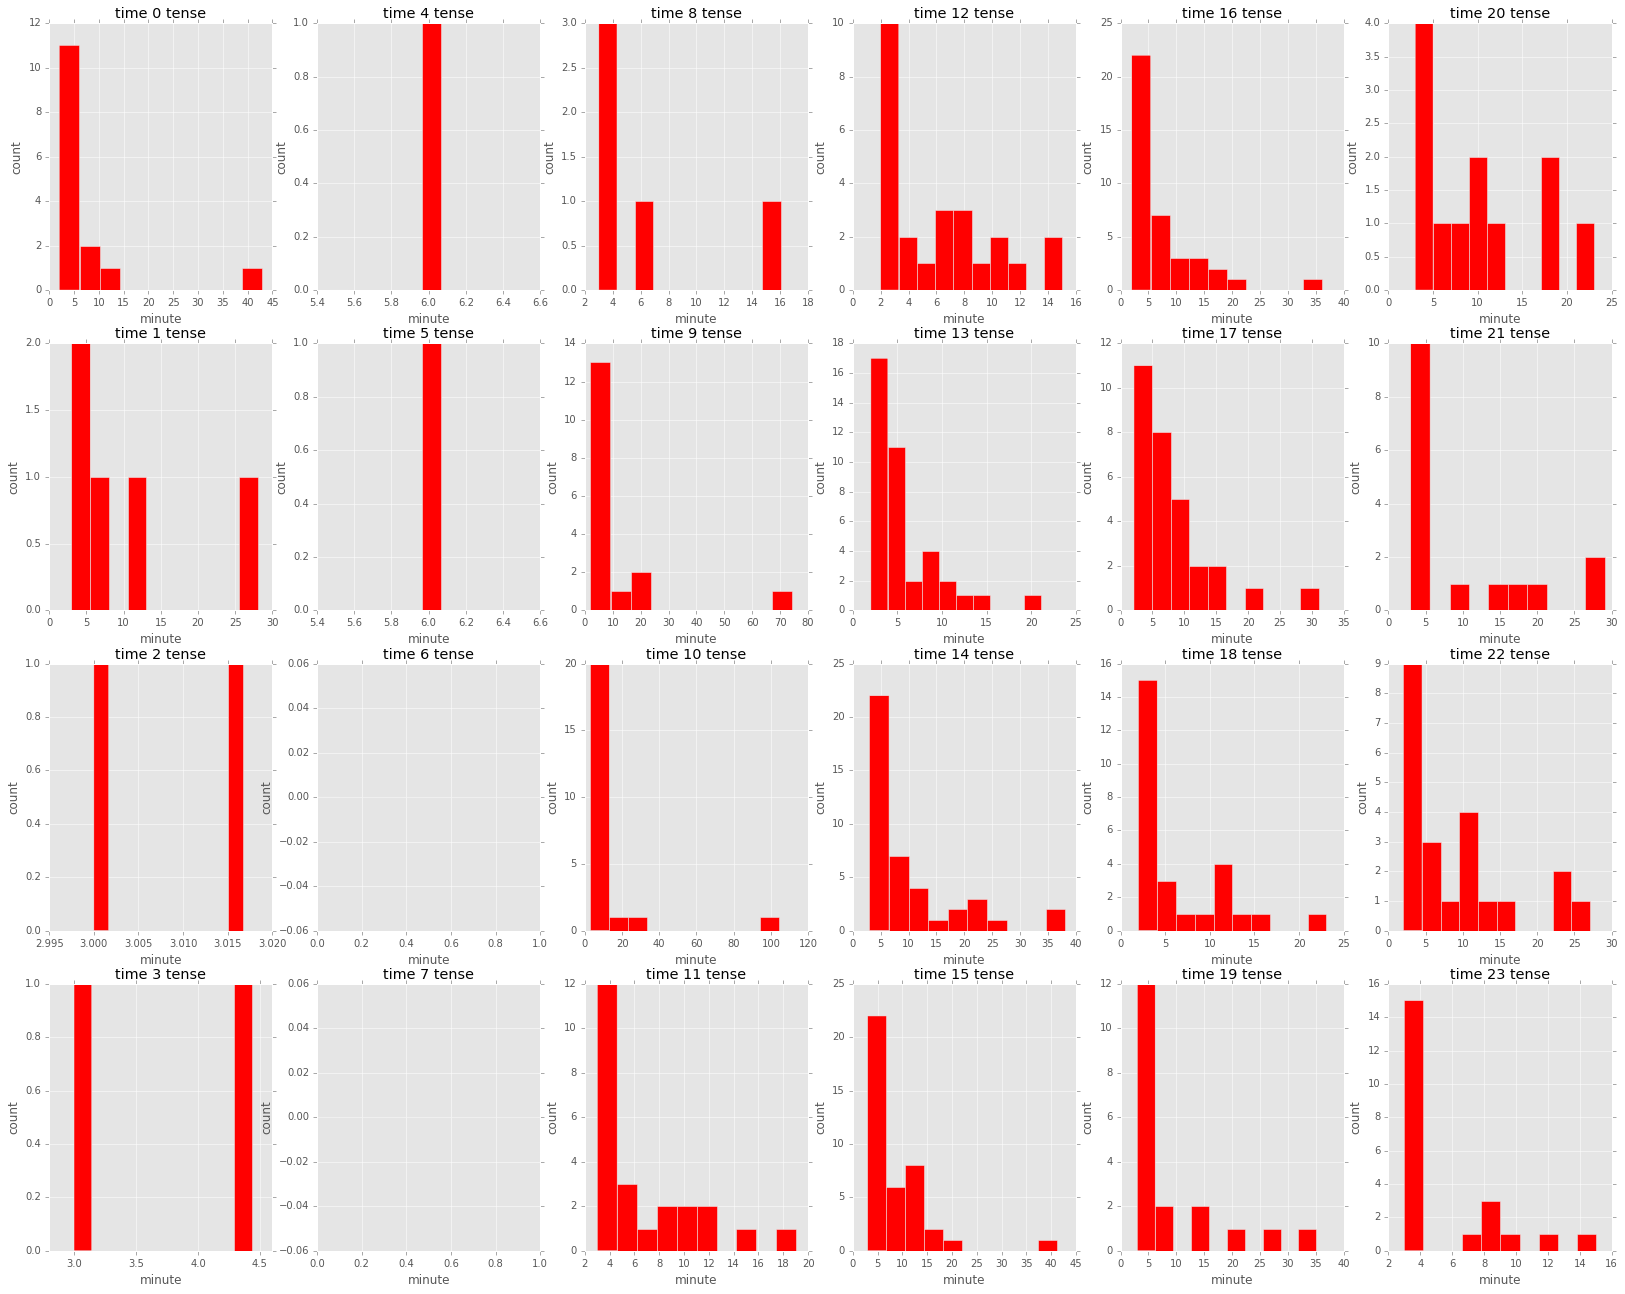

In [34]:
supportfun.hourly_count(g33, 'r', 'tense')

In [35]:
#baseline per hour
gst_0_mean = (g11.time_len/60).mean()  # calm minute per hour 12.1 
gst_1_mean = (g22.time_len/60).mean()  # focus minute per hour 17.7 
gst_2_mean = (g33.time_len/60).mean()  # tense minute per hour 7.8
gst_0_std = (g11.time_len/60).std()  # calm minute per hour 12.8
gst_1_std = (g22.time_len/60).std() # focus minute per hour 17.5
gst_2_std = (g33.time_len/60).std()  # tense minute per hour 8.8

In [37]:
trace1 = supportfun.mcmc_model(df = g11, i = 10, niter = 1000000, njobs = 2)


AttributeError: __exit__

In [80]:
t1 = trace1[99000:]
lambda_1_samples = t1['lambda_1']
p_value1 = poisson.pmf(math.ceil(lambda_1_samples.mean()), gst_0_mean)
level1 = supportfun.significant_level(gst_0_mean, lambda_1_samples.mean(), p_value1)

In [ ]:
trace2 = supportfun.mcmc_model(df = g22, i = 10, niter = 1000000, njobs = 2)

In [81]:
t2 = trace2[99000:]
lambda_2_samples = t2['lambda_1']
p_value2 = poisson.pmf(math.ceil(lambda_2_samples.mean()), gst_1_mean)
level2 = supportfun.significant_level(gst_1_mean, lambda_2_samples.mean(), p_value2)

In [ ]:
trace3 = supportfun.mcmc_model(df = g33, i = 10, niter = 1000000, njobs = 2)

In [82]:
t3 = trace3[99000:]
lambda_3_samples = t3['lambda_1']
p_value3 = poisson.pmf(math.ceil(lambda_3_samples.mean()), gst_2_mean)
level3 = supportfun.significant_level(gst_2_mean, lambda_3_samples.mean(), p_value3)

In [89]:
levels = [level3, level2, level1]

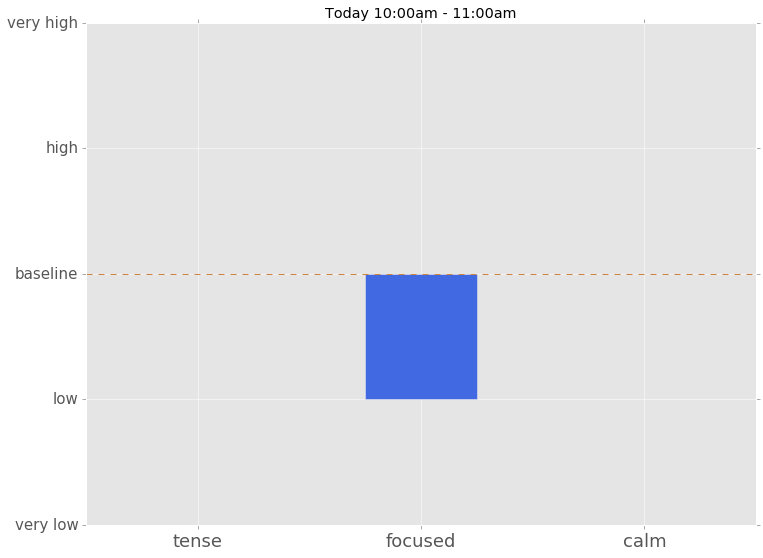

In [95]:
supportfun.plot_prediction(levels, "Today 10:00am - 11:00am")

In [154]:
pm.summary(t, varnames=['lambda_1'])


lambda_1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  13.784           1.145            0.049            [11.574, 15.998]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  11.669         13.007         13.739         14.469         16.133



In [100]:
pm.effective_n(t1)

{'lambda_1': 355, 'lambda_1_log_': 350}

In [156]:
pm.gelman_rubin(t1)

{'lambda_1': 1.0003, 'lambda_1_log_': 1.0001}